<a href="https://colab.research.google.com/github/cristinakuo/thesis-pre-research/blob/master/CTC_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import tqdm

print("CUDA available: ", torch.cuda.is_available())
dev = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)  

# ------------------------------ Loading of raw data ------------------------------

# Load files: out_lab_fea_xx.pkl
# Saves the dictionary total_set in 3 files 
# that should contain train, dev and test data (in any order)

import pickle
import numpy as np

out_folder = '/content/gdrive/My Drive/Tesis/data/'
xi = 3 # Name of the 3 files (train, dev y test) 
xf = 6

total_set = dict()
for i in range(xi,xf):
    idf = str(i)
    out_file = 'out_lab_fea_' + idf + '.pkl'

    with open(out_folder+out_file,'rb') as f:
        total = pickle.load(f)
    total_set[total[5]] = total
    
data_name_train = total_set['train'][0]
data_end_index_train = total_set['train'][1]
fea_dict_train = total_set['train'][2]
lab_dict_train = total_set['train'][3]
data_set_train = total_set['train'][4]
todo_train = total_set['train'][5]

data_name_dev = total_set['dev'][0]
data_end_index_dev = total_set['dev'][1]
fea_dict_dev = total_set['dev'][2]
lab_dict_dev = total_set['dev'][3]
data_set_dev = total_set['dev'][4]
todo_dev = total_set['dev'][5]

data_name_test = total_set['test'][0]
data_end_index_test = total_set['test'][1]
fea_dict_test = total_set['test'][2]
lab_dict_test = total_set['test'][3]
data_set_test = total_set['test'][4]
todo_test = total_set['test'][5]

# Check number of phrases in transcripts
nr_phrases_train = len(data_name_train)
nr_phrases_test = len(data_name_test)

print('Nr of phrases (train): ', nr_phrases_train)
print('Nr of phrases (test): ', nr_phrases_test)

# Split into sequences according to end indices
train_sequences = np.split(data_set_train, data_end_index_train)[:-1] # Last item is empty
test_sequences = np.split(data_set_test, data_end_index_test)[:-1]

# Conver to tensor
train_sequences = [torch.from_numpy(seq) for seq in train_sequences]
test_sequences = [torch.from_numpy(seq) for seq in test_sequences]
print('Train: split data into {} phrases.'.format(len(train_sequences)))
print('Test: split data into {} phrases.'.format(len(test_sequences)))


CUDA available:  True
Nr of phrases (train):  3696
Nr of phrases (test):  192
Train: split data into 3696 phrases.
Test: split data into 192 phrases.


In [28]:
import numpy
import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.optim as optim
from torch.nn import CTCLoss, LogSoftmax
from torch.nn.functional import log_softmax

FEATURE_DIM = 13 
NR_PHONEMES = 61
BLANK_LABEL = 61  # 0 to 60 are used
PADDING_VALUE = -1 

# *********************************************************************** #
#                           Hyper parameters
# *********************************************************************** #

BATCH_SIZE = 3
NUM_EPOCHS = 15
learning_rate = 0.01
momentum = 0.9
hidden_size = 100
layer_size = 2 # Number of layers


# *********************************************************************** #
#                             Dataset
# *********************************************************************** #

class SpeechDataset(Dataset):
  def __init__(self, list_of_sequences):
    self.data = list_of_sequences
    self.n_samples = len(list_of_sequences)
    self.seq_lens = [len(seq) for seq in list_of_sequences]
    self.n_frames = sum(self.seq_lens)

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return self.n_samples


train_dataset = SpeechDataset(train_sequences)
test_dataset = SpeechDataset(test_sequences)

print("Train Samples: {}".format(len(train_dataset)))
print("Train frames: ", train_dataset.n_frames)
print("Test Samples: {}".format(len(test_dataset)))
print("Test frames: ", test_dataset.n_frames)
print()

def remove_consecutively_repeated(sequence):
  """
  Receives list of labels and remove the ones that are repeated consecutively
  
  E.g. [27 27 28 28 28] -> [27, 28]

  """
  diff = np.diff(sequence).astype(np.bool)
  idx = np.insert(diff, 0, True)
  sequence_reduced = sequence[idx]

  return sequence_reduced


def collate_timit(batch):
    """
    batch: list of numpy arrays of different lengths
    """
    # Get length for each sequence
    input_lens = [sequence.shape[0] for sequence in batch]
    
    # Pad sequences to max length in batch
    batch_padded = pad_sequence(batch, batch_first=True, padding_value=PADDING_VALUE)
    batch_padded = torch.as_tensor(batch_padded)
    
    # Get batched input
    x_batch = batch_padded[:,:,:-1]
    
    # Obtain targets
    y_batch = [seq[:,-1] for seq in batch]

    # Remove repeated consecutive labels in target sequences: (E.g. [27 27 28 28 28 61] -> [27 28 61])
    # NOTE: This is done to make targets shorter than input, so that nn.CTCLoss doesn't yield infinite values
    y_batch_reduced = []
    target_lens = []
    for y_seq in y_batch: # Loop over each sequence
      y_seq_reduced = remove_consecutively_repeated(y_seq)
      y_batch_reduced.append(y_seq_reduced)
      target_lens.append(len(y_seq_reduced))

    # Pad target sequences
    y_batch_padded = pad_sequence(y_batch_reduced, batch_first=True, padding_value=PADDING_VALUE)
    
    y_batch = torch.as_tensor(y_batch_padded)
    
    return x_batch, y_batch, input_lens, target_lens


# *********************************************************************** #
#                           Model
# *********************************************************************** #

class BLSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, nr_layers, output_size):
    super(BLSTMModel, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.nr_layers = nr_layers

    # Hidden layer
    # batch_first=True means input/output tensors to be of shape
    # (batch_dim, seq_dim, feature_dim)
    self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.nr_layers, 
                        batch_first=True, bidirectional=True, bias=True)
    
    # Output Layer
    # Input is hidden_size*2 because it has a bidirectional LSTM as previous layer
    self.fc = torch.nn.Linear(self.hidden_size*2, self.output_size, bias=True)

    self.log_softmax = LogSoftmax(dim=2)

  def forward(self, x, seq_lens): # x has shape [batch_size, max_seq_len, nr_coef]

    x_packed = pack_padded_sequence(x, lengths=seq_lens, batch_first=True, enforce_sorted=False) # x_packed.data has shape [nr_batch_frames, nr_coefs]
    out_lstm, _ = self.lstm(x_packed) # out_lstm.data has shape [nr_batch_frames, nr_coefs]

    out_lstm_padded, out_lens = pad_packed_sequence(out_lstm, batch_first=True, padding_value=PADDING_VALUE) # [batch_size, sequences_max_len, nr_coefs]

    out = self.fc(out_lstm_padded) # [batch_size, sequences_max_len, nr_classes] 
    # CTCLoss will ignore the padding values as sequences lengths from input and target are passed to it

    
    return out, out_lens



# *********************************************************************** #
#                           Decoding
# *********************************************************************** #

def greedy_decoding(sequences, sequence_lens, blank_label, remove_blanks=False):
  """
  For each timestemp, takes the label with maximum probability.
  Removes blank labels if remove_blanks is set to True.

  :param sequences: torch tensor [batch, sequence len, number of classes]
  :param blank_label: blank label
  :param sequence_lens: list of sequence lengths for each sequence in batch
  :return: list of decoded sequences (different lengths).
  """

  decoded_sequences = []
  for sequence, seq_len in zip(sequences, sequence_lens):
    seq = sequence[:seq_len]  # Remove pads
    decoded_seq = torch.argmax(seq, dim=1)

    if remove_blanks:
      decoded_seq = decoded_seq[decoded_seq != blank_label]

    decoded_sequences.append(decoded_seq)

  return decoded_sequences


def print_distances(distances, token1Length, token2Length):
  for t1 in range(token1Length + 1):
      for t2 in range(token2Length + 1):
          print(int(distances[t1][t2]), end=" ")
      print()

def levenshtein_distance(token1, token2, debug=False):
  """
  Computes the Edit Distance between two sequences.
  """
  distances = numpy.zeros((len(token1) + 1, len(token2) + 1))

  for t1 in range(len(token1) + 1):
    distances[t1][0] = t1

  for t2 in range(len(token2) + 1):
    distances[0][t2] = t2
        
  a = 0
  b = 0
  c = 0
  
  for t1 in range(1, len(token1) + 1):
    for t2 in range(1, len(token2) + 1):
      if (token1[t1-1] == token2[t2-1]):
          distances[t1][t2] = distances[t1 - 1][t2 - 1]
      else:
          a = distances[t1][t2 - 1]
          b = distances[t1 - 1][t2]
          c = distances[t1 - 1][t2 - 1]             
          min_dist = min((a,b,c))

          distances[t1][t2] = min_dist + 1

  if debug:
    print_distances(distances, len(token1), len(token2))
    
  return distances[len(token1)][len(token2)]


def label_error_rate(predicted_sequences, target_sequences, predicted_lens, target_lens, debug=False):
  total_distance = 0
  
  nr_batches = len(predicted_sequences)

  for i in range(nr_batches):
    pred_seq = predicted_sequences[i]
    target_seq = target_sequences[i]
    predicted_len = predicted_lens[i]
    target_len = target_lens[i]

    pred_seq = pred_seq[:predicted_len]
    target_seq = target_seq[:target_len]

    dist = levenshtein_distance(pred_seq, target_seq)
    total_distance += dist

  target_total_len = sum(target_lens)
  label_err_rate = float(total_distance)/float(target_total_len)*100 # Although LER it's not a real percentage, as it could be > %100
  
  if debug:
    print("Total distance ", total_distance)
    print("Target total len ", target_total_len)

  return label_err_rate


# *********************************************************************** #
#                        Train & Test functions
# *********************************************************************** #

def train_model(model, data_loader):

  model.train()
  
  epoch_loss = 0

  for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))): 
    # Save to device
    input_data = input_data.to(torch.float)
    target_data = target_data.to(torch.long)
    input_data, target_data = input_data.to(device), target_data.to(device)
    
    optimizer.zero_grad() # Clear grads before doing backward
    
    # Forward pass
    model_out, out_lens = model(input_data, seq_lens) # [batch_size, seq_len, classes]

    # Prepare CTC inputs
    model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
    model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
    input_lens = out_lens.to(torch.long)
    target_lens = torch.tensor(target_lens, dtype=torch.long)

    batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
    epoch_loss += batch_loss.item()
    
    # Backward pass
    batch_loss.backward()
    optimizer.step()

  epoch_loss = epoch_loss/len(data_loader.dataset) # Divide by number of sequences

  return epoch_loss

def test_model(model, data_loader):

  # This will notify all the layers that it's eval mode, that way, 
  # batchnorm or dropout layers will work in eval mode instead of training mode.
  model.eval()

  total_loss = 0
  nr_correct_frames = 0
  total_frames = 0
  label_err_rates = []
  # no_grad impacts the autograd engine and deactivate it. 
  # It will reduce memory usage and speed up computations 
  # and it won’t be able to backprop (which is not desired 
  # in an eval script).
  with torch.no_grad(): 
    for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))):
      input_data = input_data.to(torch.float)
      target_data = target_data.to(torch.long)
      input_data, target_data = input_data.to(device), target_data.to(device)  
      
      model_out, out_lens = model(input_data, seq_lens)

      # Prepare CTC inputs
      model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
      model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
      input_lens = out_lens.to(torch.long)
      target_lens = torch.tensor(target_lens, dtype=torch.long) 

      # Compute loss
      batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
      total_loss += batch_loss.item()

      # Predict
      predictions = greedy_decoding(model_out, input_lens, blank_label=BLANK_LABEL, remove_blanks=True)
      
      # Get error
      label_err_rate = label_error_rate(predictions, target_data, input_lens, target_lens)
      label_err_rates.append(label_err_rate)

  average_loss = total_loss/len(data_loader.dataset) # Divide by number sequences
  avg_label_err_rate = sum(label_err_rates)/len(label_err_rates)

  print(label_err_rates)
  print(avg_label_err_rate)

  return average_loss, avg_label_err_rate


# **************************** Instantiate model & train ******************************** #

input_size = FEATURE_DIM
output_size = NR_PHONEMES + 1  # Number of phonemes + 1 for blank label

model = BLSTMModel(input_size, hidden_size, layer_size, output_size)
model = model.to(device)

cost_function = nn.CTCLoss(blank=BLANK_LABEL, zero_infinity=False)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

print("Created BLSTM model with parameters:")
print("Input size: ", input_size)
print("Hidden size: ", hidden_size)
print("Layer size: ", layer_size)
print("Output size: ", output_size)
print("Batch size: ", BATCH_SIZE)

losses = []
label_error_rates = []

for epoch in range(NUM_EPOCHS):
  print("Epoch nr: ", epoch + 1)

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit)
  train_loss = train_model(model, train_loader)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit)
  test_loss, test_label_error_rate = test_model(model, test_loader)
  losses.append(test_loss)
  label_error_rates.append(test_label_error_rate)
  print("---- Training results ----")
  print("Loss:", train_loss)
  print("---- Test results ----")
  print("Loss:", test_loss)
  print("Label error rate:", test_label_error_rate)
  print()

Train Samples: 3696
Train frames:  1124823
Test Samples: 192
Test frames:  57919

Created BLSTM model with parameters:
Input size:  13
Hidden size:  100
Layer size:  2
Output size:  62
Batch size:  3
Epoch nr:  1



[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
100.0
---- Training results ----
Loss: 1.3332158190992487
---- Test results ----
Loss: 1.21048903465271
Label error rate: 100.0

Epoch nr:  2



[89.47368421052632, 94.11764705882352, 82.05128205128204, 81.25, 93.33333333333333, 85.29411764705883, 89.1566265060241, 92.3913043478261, 85.29411764705883, 85.22727272727273, 85.85858585858585, 88.23529411764706, 92.3913043478261, 88.60759493670885, 90.10989010989012, 86.66666666666667, 87.61904761904762, 90.0, 91.35802469135803, 90.0, 94.31818181818183, 81.25, 86.40776699029125, 90.65420560747664, 90.990990990991, 86.86868686868688, 89.79591836734694, 91.01123595505618, 91.81818181818183, 94.16666666666667, 90.9090909090909, 88.59649122807018, 90.5982905982906, 91.81818181818183, 90.81632653061224, 85.81560283687944, 86.08695652173914, 87.39495798319328, 87.93103448275862, 95.23809523809523, 85.83333333333333, 91.85185185185185, 94.53125, 89.1891891891892, 88.88888888888889, 88.97058823529412, 94.23076923076923, 89.84375, 86.61417322834646, 88.57142857142857, 90.56603773584906, 91.59663865546219, 87.73006134969326, 90.0, 88.81987577639751, 88.51351351351352, 94.07894736842105, 91.3


[77.19298245614034, 76.47058823529412, 64.1025641025641, 60.9375, 69.33333333333334, 64.70588235294117, 72.28915662650603, 66.30434782608695, 67.64705882352942, 67.04545454545455, 67.67676767676768, 67.64705882352942, 64.13043478260869, 72.15189873417721, 65.93406593406593, 70.0, 72.38095238095238, 64.54545454545455, 69.1358024691358, 68.75, 77.27272727272727, 62.5, 67.96116504854369, 64.48598130841121, 70.27027027027027, 68.68686868686868, 71.42857142857143, 65.1685393258427, 70.0, 70.0, 74.74747474747475, 63.1578947368421, 74.35897435897436, 70.0, 70.40816326530613, 66.66666666666666, 70.43478260869566, 74.78991596638656, 66.37931034482759, 67.61904761904762, 67.5, 66.66666666666666, 75.78125, 70.27027027027027, 69.04761904761905, 68.38235294117648, 73.07692307692307, 66.40625, 70.07874015748031, 68.57142857142857, 68.55345911949685, 73.10924369747899, 68.71165644171779, 65.0, 71.42857142857143, 73.64864864864865, 69.73684210526315, 71.33333333333334, 68.125, 76.74418604651163, 72.9


[68.42105263157895, 62.745098039215684, 56.41025641025641, 51.5625, 57.333333333333336, 50.0, 65.06024096385542, 56.52173913043478, 54.41176470588235, 51.13636363636363, 56.56565656565656, 53.92156862745098, 60.86956521739131, 56.9620253164557, 52.74725274725275, 55.55555555555556, 55.23809523809524, 50.0, 51.85185185185185, 47.5, 62.5, 48.214285714285715, 56.310679611650485, 57.009345794392516, 64.86486486486487, 43.43434343434344, 54.08163265306123, 46.06741573033708, 57.27272727272727, 57.49999999999999, 58.58585858585859, 51.75438596491229, 61.53846153846154, 55.45454545454545, 47.95918367346938, 51.77304964539007, 57.391304347826086, 58.82352941176471, 58.620689655172406, 53.333333333333336, 54.166666666666664, 55.55555555555556, 63.28125, 54.95495495495496, 49.2063492063492, 52.94117647058824, 51.92307692307693, 55.46875, 55.90551181102362, 56.42857142857143, 56.60377358490566, 57.98319327731093, 55.21472392638037, 57.49999999999999, 52.17391304347826, 57.432432432432435, 50.657


[73.68421052631578, 64.70588235294117, 58.97435897435898, 51.5625, 49.333333333333336, 42.64705882352941, 56.62650602409639, 53.2608695652174, 51.470588235294116, 46.590909090909086, 55.55555555555556, 51.9607843137255, 52.17391304347826, 58.22784810126582, 49.45054945054945, 55.55555555555556, 50.476190476190474, 45.45454545454545, 46.913580246913575, 40.0, 60.22727272727273, 48.214285714285715, 48.54368932038835, 50.467289719626166, 62.16216216216216, 43.43434343434344, 43.87755102040816, 50.56179775280899, 50.90909090909091, 51.66666666666667, 55.55555555555556, 53.50877192982456, 55.55555555555556, 53.63636363636364, 46.93877551020408, 46.808510638297875, 52.17391304347826, 57.98319327731093, 54.310344827586206, 49.523809523809526, 47.5, 53.333333333333336, 59.375, 49.549549549549546, 49.2063492063492, 45.588235294117645, 53.84615384615385, 53.90625, 53.54330708661418, 50.71428571428571, 44.0251572327044, 51.26050420168067, 57.05521472392638, 52.5, 52.17391304347826, 56.7567567567


[68.42105263157895, 52.94117647058824, 52.56410256410257, 46.875, 41.333333333333336, 44.11764705882353, 61.44578313253012, 44.565217391304344, 45.588235294117645, 42.04545454545455, 55.55555555555556, 49.01960784313725, 57.608695652173914, 50.63291139240506, 49.45054945054945, 54.44444444444444, 42.857142857142854, 49.09090909090909, 46.913580246913575, 37.5, 63.63636363636363, 47.32142857142857, 47.57281553398058, 48.598130841121495, 55.85585585585585, 43.43434343434344, 50.0, 48.31460674157304, 45.45454545454545, 54.166666666666664, 51.515151515151516, 50.877192982456144, 58.97435897435898, 53.63636363636364, 43.87755102040816, 45.39007092198582, 50.43478260869565, 55.46218487394958, 50.0, 52.38095238095239, 47.5, 51.11111111111111, 58.59375, 50.45045045045045, 50.79365079365079, 47.05882352941176, 48.07692307692308, 51.5625, 51.96850393700787, 39.285714285714285, 49.685534591194966, 56.30252100840336, 52.760736196319016, 51.87500000000001, 54.037267080745345, 54.054054054054056, 5


[71.9298245614035, 56.86274509803921, 53.84615384615385, 45.3125, 46.666666666666664, 44.11764705882353, 54.21686746987952, 43.47826086956522, 44.11764705882353, 40.909090909090914, 55.55555555555556, 45.09803921568628, 54.347826086956516, 48.10126582278481, 49.45054945054945, 54.44444444444444, 41.904761904761905, 49.09090909090909, 44.44444444444444, 42.5, 55.68181818181818, 47.32142857142857, 52.42718446601942, 51.4018691588785, 61.261261261261254, 52.52525252525253, 48.97959183673469, 51.68539325842697, 44.54545454545455, 51.66666666666667, 51.515151515151516, 50.877192982456144, 54.700854700854705, 50.90909090909091, 53.06122448979592, 46.09929078014184, 46.08695652173913, 56.30252100840336, 54.310344827586206, 50.476190476190474, 51.66666666666667, 52.59259259259259, 56.25, 48.64864864864865, 48.41269841269841, 52.20588235294118, 46.15384615384615, 60.9375, 55.90551181102362, 42.857142857142854, 45.911949685534594, 59.66386554621849, 53.37423312883436, 53.125, 54.6583850931677, 


[64.91228070175438, 58.82352941176471, 43.58974358974359, 53.125, 48.0, 45.588235294117645, 56.62650602409639, 43.47826086956522, 47.05882352941176, 40.909090909090914, 50.505050505050505, 49.01960784313725, 57.608695652173914, 51.89873417721519, 50.54945054945055, 51.11111111111111, 41.904761904761905, 50.90909090909091, 51.85185185185185, 41.25, 55.68181818181818, 49.107142857142854, 50.48543689320388, 47.66355140186916, 56.75675675675676, 46.464646464646464, 54.08163265306123, 47.19101123595505, 43.63636363636363, 56.666666666666664, 50.505050505050505, 50.877192982456144, 51.28205128205128, 47.27272727272727, 54.08163265306123, 44.680851063829785, 52.17391304347826, 58.82352941176471, 62.06896551724138, 54.285714285714285, 50.83333333333333, 48.148148148148145, 55.46875, 56.75675675675676, 46.82539682539682, 50.0, 47.11538461538461, 53.125, 55.118110236220474, 40.714285714285715, 47.79874213836478, 53.78151260504202, 53.987730061349694, 56.25, 52.17391304347826, 52.702702702702695


[63.1578947368421, 60.78431372549019, 46.15384615384615, 51.5625, 49.333333333333336, 51.470588235294116, 46.98795180722892, 38.04347826086957, 47.05882352941176, 43.18181818181818, 50.505050505050505, 42.15686274509804, 58.69565217391305, 48.10126582278481, 48.35164835164835, 50.0, 43.80952380952381, 48.18181818181818, 48.148148148148145, 41.25, 53.40909090909091, 52.67857142857143, 50.48543689320388, 46.728971962616825, 54.054054054054056, 42.42424242424242, 48.97959183673469, 46.06741573033708, 44.54545454545455, 49.166666666666664, 52.52525252525253, 44.73684210526316, 54.700854700854705, 39.09090909090909, 50.0, 43.97163120567376, 49.56521739130435, 54.621848739495796, 53.44827586206896, 44.761904761904766, 50.0, 51.11111111111111, 51.5625, 52.25225225225225, 42.857142857142854, 44.85294117647059, 55.769230769230774, 53.125, 53.54330708661418, 40.714285714285715, 45.911949685534594, 57.98319327731093, 50.920245398773, 53.75, 50.931677018633536, 54.054054054054056, 56.578947368421


[64.91228070175438, 62.745098039215684, 51.28205128205128, 54.6875, 44.0, 45.588235294117645, 55.42168674698795, 45.65217391304348, 52.94117647058824, 42.04545454545455, 52.52525252525253, 49.01960784313725, 50.0, 48.10126582278481, 51.64835164835166, 44.44444444444444, 40.95238095238095, 44.54545454545455, 44.44444444444444, 41.25, 51.13636363636363, 46.42857142857143, 49.51456310679612, 49.532710280373834, 62.16216216216216, 45.45454545454545, 46.93877551020408, 52.80898876404494, 45.45454545454545, 50.0, 56.56565656565656, 50.0, 56.41025641025641, 42.72727272727273, 42.857142857142854, 43.97163120567376, 52.17391304347826, 58.82352941176471, 60.3448275862069, 51.42857142857142, 54.166666666666664, 46.666666666666664, 55.46875, 45.94594594594595, 46.03174603174603, 44.11764705882353, 49.03846153846153, 50.0, 49.60629921259843, 45.714285714285715, 46.540880503144656, 58.82352941176471, 47.85276073619632, 52.5, 50.931677018633536, 52.702702702702695, 50.6578947368421, 50.6666666666666


[61.40350877192983, 58.82352941176471, 44.871794871794876, 56.25, 38.666666666666664, 52.94117647058824, 56.62650602409639, 43.47826086956522, 52.94117647058824, 43.18181818181818, 52.52525252525253, 44.11764705882353, 61.95652173913043, 40.50632911392405, 49.45054945054945, 45.55555555555556, 46.666666666666664, 45.45454545454545, 45.67901234567901, 43.75, 53.40909090909091, 49.107142857142854, 47.57281553398058, 52.336448598130836, 57.65765765765766, 47.474747474747474, 48.97959183673469, 51.68539325842697, 46.36363636363636, 50.83333333333333, 57.57575757575758, 47.368421052631575, 54.700854700854705, 46.36363636363636, 46.93877551020408, 44.680851063829785, 50.43478260869565, 59.66386554621849, 52.58620689655172, 48.57142857142857, 46.666666666666664, 51.85185185185185, 53.125, 52.25225225225225, 45.23809523809524, 48.529411764705884, 47.11538461538461, 54.6875, 57.48031496062992, 40.714285714285715, 47.79874213836478, 57.14285714285714, 52.760736196319016, 50.0, 55.90062111801242


[61.40350877192983, 58.82352941176471, 48.717948717948715, 50.0, 37.333333333333336, 57.35294117647059, 50.602409638554214, 44.565217391304344, 51.470588235294116, 46.590909090909086, 52.52525252525253, 46.07843137254902, 58.69565217391305, 44.303797468354425, 50.54945054945055, 51.11111111111111, 46.666666666666664, 49.09090909090909, 45.67901234567901, 38.75, 48.86363636363637, 49.107142857142854, 42.71844660194174, 44.85981308411215, 57.65765765765766, 46.464646464646464, 45.91836734693878, 53.93258426966292, 43.63636363636363, 49.166666666666664, 54.54545454545454, 48.24561403508772, 50.427350427350426, 45.45454545454545, 46.93877551020408, 43.97163120567376, 38.26086956521739, 62.18487394957983, 53.44827586206896, 46.666666666666664, 46.666666666666664, 51.85185185185185, 49.21875, 46.846846846846844, 49.2063492063492, 47.05882352941176, 50.0, 49.21875, 51.96850393700787, 41.42857142857143, 48.42767295597484, 57.14285714285714, 50.306748466257666, 48.75, 51.5527950310559, 49.3243


[64.91228070175438, 64.70588235294117, 47.43589743589743, 56.25, 40.0, 50.0, 51.80722891566265, 43.47826086956522, 50.0, 44.31818181818182, 49.494949494949495, 42.15686274509804, 56.52173913043478, 51.89873417721519, 52.74725274725275, 47.77777777777778, 41.904761904761905, 45.45454545454545, 48.148148148148145, 41.25, 53.40909090909091, 47.32142857142857, 52.42718446601942, 47.66355140186916, 59.45945945945946, 45.45454545454545, 50.0, 53.93258426966292, 40.909090909090914, 53.333333333333336, 56.56565656565656, 45.614035087719294, 51.28205128205128, 46.36363636363636, 46.93877551020408, 46.808510638297875, 50.43478260869565, 58.82352941176471, 55.172413793103445, 45.714285714285715, 47.5, 47.40740740740741, 48.4375, 49.549549549549546, 44.44444444444444, 45.588235294117645, 49.03846153846153, 49.21875, 55.90551181102362, 37.857142857142854, 46.540880503144656, 55.46218487394958, 50.306748466257666, 51.24999999999999, 49.06832298136646, 48.64864864864865, 50.6578947368421, 56.0000000


[70.17543859649122, 60.78431372549019, 44.871794871794876, 53.125, 48.0, 52.94117647058824, 51.80722891566265, 45.65217391304348, 45.588235294117645, 45.45454545454545, 53.535353535353536, 44.11764705882353, 53.2608695652174, 48.10126582278481, 49.45054945054945, 48.888888888888886, 42.857142857142854, 47.27272727272727, 43.20987654320987, 38.75, 53.40909090909091, 47.32142857142857, 44.66019417475729, 47.66355140186916, 59.45945945945946, 51.515151515151516, 48.97959183673469, 51.68539325842697, 45.45454545454545, 50.0, 54.54545454545454, 46.49122807017544, 52.991452991452995, 46.36363636363636, 52.04081632653062, 46.808510638297875, 43.47826086956522, 61.34453781512605, 56.896551724137936, 46.666666666666664, 45.0, 49.629629629629626, 50.78125, 46.846846846846844, 48.41269841269841, 45.588235294117645, 45.19230769230769, 50.78125, 57.48031496062992, 37.857142857142854, 50.943396226415096, 52.94117647058824, 55.21472392638037, 46.25, 49.68944099378882, 52.02702702702703, 50.0, 57.999


[61.40350877192983, 64.70588235294117, 47.43589743589743, 46.875, 42.66666666666667, 48.529411764705884, 46.98795180722892, 42.391304347826086, 48.529411764705884, 39.77272727272727, 51.515151515151516, 48.03921568627451, 56.52173913043478, 43.037974683544306, 51.64835164835166, 47.77777777777778, 44.761904761904766, 45.45454545454545, 44.44444444444444, 38.75, 59.09090909090909, 50.89285714285714, 45.63106796116505, 43.925233644859816, 60.36036036036037, 48.484848484848484, 47.95918367346938, 50.56179775280899, 45.45454545454545, 52.5, 51.515151515151516, 43.859649122807014, 52.991452991452995, 46.36363636363636, 51.02040816326531, 46.808510638297875, 44.34782608695652, 56.30252100840336, 55.172413793103445, 46.666666666666664, 45.0, 49.629629629629626, 49.21875, 54.054054054054056, 50.79365079365079, 49.26470588235294, 45.19230769230769, 50.0, 52.75590551181102, 38.57142857142858, 47.16981132075472, 52.94117647058824, 50.306748466257666, 53.125, 52.79503105590062, 48.64864864864865,

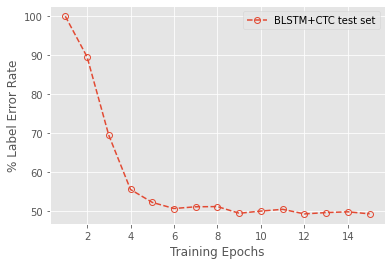

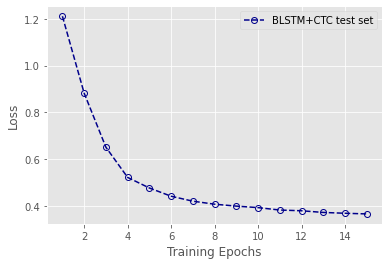

In [29]:
import datetime
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# ------------ Label error rates ----------------

fig, ax = plt.subplots()
epochs = np.arange(1, NUM_EPOCHS+1)
ax.plot(epochs, label_error_rates, '--o', markerfacecolor='None', label='BLSTM+CTC test set')

ax.set(xlabel='Training Epochs', ylabel='% Label Error Rate')

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/CTC/'
date_of_training = str(datetime.date.today())
filename = date_of_training + '_' + str(NUM_EPOCHS) + 'epochs' + suffix
learning_curve_filepath = root_path +'LER_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()

# ------------ Losses ----------------

fig, ax = plt.subplots()
epochs = np.arange(1, NUM_EPOCHS+1)
ax.plot(epochs, losses, '--o', markerfacecolor='None', color='darkblue', label='BLSTM+CTC test set')

ax.set(xlabel='Training Epochs', ylabel='Loss')

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/CTC/'
date_of_training = str(datetime.date.today())
filename = date_of_training + '_' + str(NUM_EPOCHS) + 'epochs' + suffix
learning_curve_filepath = root_path +'loss_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()